<a href="https://colab.research.google.com/github/AlexandreAdam/torch_score_models/blob/master/score_based_modeling_overview_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Utility functions, make sure to run this cell
!pip install torchquad --quiet

%matplotlib inline

import torch
import numpy
import matplotlib.pyplot as plt
import torch.distributions as tfd
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.pylab as pylab
import matplotlib.cm as cm
plt.style.use("dark_background")
params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def density_scatter(points, fig=None, ax=None, sort=True, bins=20, cmap="magma", norm=None, ticks=None, colorbar=False, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    x = points[:, 0]
    y = points[:, 1]
    if ax is None:
        fig, ax = plt.subplots()
    data, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    x_bins = 0.5 * (x_edges[1:] + x_edges[:-1])
    y_bins = 0.5 * (y_edges[1:] + y_edges[:-1])
    z = interpn((x_bins, y_bins), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    if norm is None:
        norm = Normalize(vmin=z.min(), vmax=z.max())
    ax.scatter(x, y, c=z, cmap=cmap, norm=norm, **kwargs)
    if fig is not None:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax, ticks=ticks)
        cax.set_ylabel('Density')
    return ax

def vector_field(gradient_function, xmin, xmax, ymin, ymax, n=20, dx=0.05, scale=1.5e3, width=0.007, fig=None, ax=None):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    g = gradient_function(torch.tensor(points).to(DEVICE).float()).detach().numpy().reshape([n, n, 2])
    colors = np.sqrt(g[..., 0]**2 + g[..., 1]**2).ravel()
    if ax is None:
        fig, ax = plt.subplots()
    norm = Normalize()
    colormap = cm.magma
    ax.quiver(x, y, g[..., 0], g[..., 1], color=colormap(norm(colors)), scale=scale, width=width)
    if fig is not None:
        sm = cm.ScalarMappable(norm=norm, cmap=colormap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel(r"$|| \nabla_{\mathbf{x}} \log p(\mathbf{x})||$")
    return ax

def density_contours(density_function, xmin, xmax, ymin, ymax, confidence_intervals, dx=0.01, dy=0.01, fig=None, ax=None):
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    n = x.size
    m = y.size
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    p = density_function(torch.tensor(points).to(DEVICE)).detach().numpy().reshape([m, n])
    if ax is None:
        fig, ax = plt.subplots()

    cumul = np.sort(p.ravel() * dx * dy)[::-1].cumsum()
    ps = []
    len_ci = len(confidence_intervals)
    for ci in confidence_intervals:
        p_at_ci = np.sort(p.ravel())[::-1][np.argmin((cumul - ci)**2)]
        ps.append(p_at_ci)
    cs = ax.contour(x, y, p, levels=ps[::-1], colors=[plt.cm.cool(i/(len_ci-1)) for i in range(len_ci)], linewidths=2, linestyles="--")

    def fmt(x):
        ci = cumul[np.argmin((x - np.sort(p.ravel())[::-1])**2)]
        s = f"{ci*100:.1f}"
        if s.endswith("0"):
            s = f"{ci*100:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

    return ax

def four_gaussians(size=1, mode_width=0.1):
    coords = torch.tensor([
        [size, size],
        [size, -size],
        [-size, size],
        [-size, -size]
    ]).to(DEVICE, torch.float32)
    mixture = tfd.Categorical(probs=torch.ones(4).to(DEVICE), validate_args=False)
    component = tfd.Independent(tfd.Normal(loc=coords, scale=mode_width, validate_args=False), 1)
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)

dist = four_gaussians()

# What is the score?

In statistics, the score is a measure of how steeply a probability distribution rises or falls at a particular point. It is calculated as the gradient of the logarithm of the probability density function (PDF) at that point.
$$
  \mathbf{s}(\mathbf{x}) \equiv \nabla_{\mathbf{x}}\log p(\mathbf{x})
$$

The score is a valuable concept in statistics because it has two important properties. Firstly, it can be approximated very accurately by any universal approximator, i.e. a function that can approximate other functions well. Secondly, the score is used as the foundation of many efficient algorithms for sampling from probability distributions, such as the Metropolis-adjusted Langevin dynamics, Hamiltonian Monte Carlo, and diffusion algorithms.


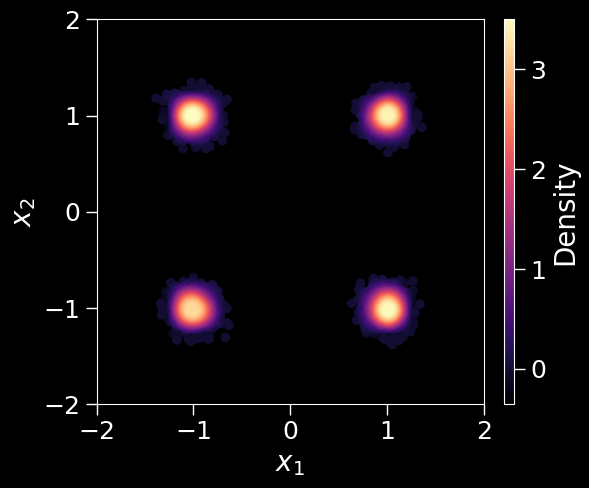

In [4]:
# @title
# We can sample from the distribution
x = dist.sample([10000])
ax = density_scatter(x.cpu().numpy())
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

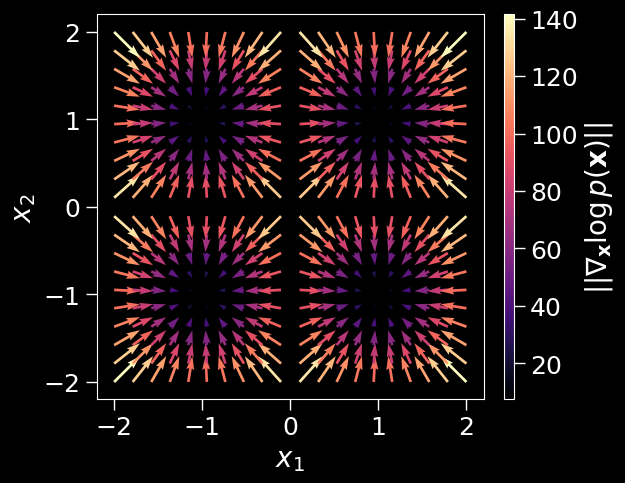

In [5]:
# @title
# We can get access to the score using automatic differentiation
# Since grad expect a scalar, we use grad and vmap together for a batched gradient
from torch.func import grad
from torch import vmap # parallelize a function over its batch dimension
def true_score(x):
    return vmap(grad(dist.log_prob))(x)

ax = vector_field(true_score, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05)
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

## Brownian motion


Brownian motion is defined as a Wiener process $\mathbf{W}$, for which you can find more info [here](https://en.wikipedia.org/wiki/Wiener_process). In essence, this process describes the motion of a particle undergoing a random process, such that the distance traversed by the particle after a time $t$ of this process should be, on average, $\sqrt{t}$.

To be more precise, let us define the Wiener process has follows. First, we define the average value of this process at time $t$, which we set to 0 for any time $t$:
$$
  \mathbb{E}[\mathbf{w}_t] = 0
$$
Next, we define the covariance of the Wiener process at different time, $t_1$ and $t_0$, with $t_1 > t_0$. This quantity will encode this notion of distance mentionned above
$$
  \mathbb{E} \big[ \mathbf{w}_{t_1}\mathbf{w}_{t_0} \big] = t_1 - t_0
$$
With these definition, we can define the distribution of the distance of a particle undergoing a Brownian process
$$
  \mathbf{w}_{t_1} - \mathbf{w}_{t_0} \sim \mathcal{N}(0, t)
$$
Note that $t$ is the **variance** of the Gaussian distribution. The standard deviation would be $\sqrt{t}$, which would also correspond to the distance.
We can rewrite this more compactly as
$$
  \Delta \mathbf{w}_{\Delta t} \sim \mathcal{N}(0, \Delta t)
$$

The Euler-Maruyama discretisation of Brownian motion takes advantage of this last fact in order to reparametrize the process in terms of quantity we can compute on the fly:
$$
  \Delta \mathbf{w}_{\Delta t} \approx \mathbf{z} \sqrt{\Delta t}
$$
where $\mathbf{z} \sim \mathcal{N}(0, \mathbb{1})$ is a normal random variable.

In what follows, you will create a function that performs a random walk using Brownian motion.

In [3]:
def random_walk_step(x, dt):
    # Create a random walk by adding the discretized Brownian motion random variable to x
    # Do not use inplace operation like +=
    return ...


W = 1 # Number of walkers to plot

<ipython-input-4-b82e33c3594c>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', iterations)


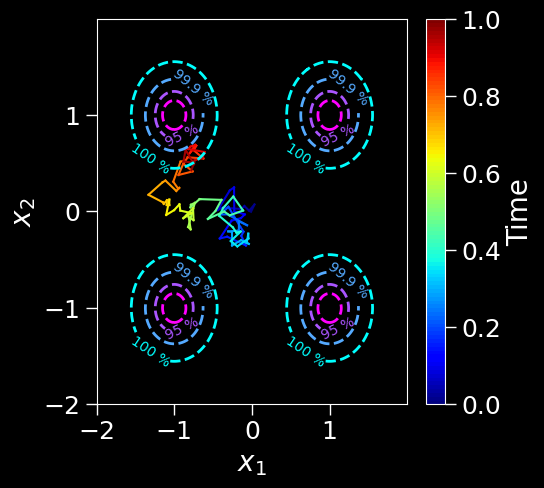

In [4]:
# @title Visualize a Brownian motion
# First, let us now consider only random walk

iterations = 100
dt = 0.01
sigma_init = 0.01
x = torch.randn([W, 2]) * sigma_init # some initial conditions
random_walk = [x]
for _ in range(iterations):
    x = random_walk_step(x, dt)
    random_walk.append(x.cpu().numpy())
random_walk = np.stack(random_walk, axis=1)

# Plot the random walk with a color gradient showing evolution
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('jet', iterations)
for w in range(W):
    for i in range(iterations-1):
        ax.plot(random_walk[w, i:i+2, 0], random_walk[w, i:i+2, 1], color=cmap(i))
# For reference, we plot the density contours on top of the random walk
def density(x):
    return torch.exp(dist.log_prob(x))
ax = density_contours(density, xmin=-2, xmax=2, ymin=-2, ymax=2, confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=ax)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, iterations * dt))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time')

ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

## Langevin dynamics

Now we will add a the gradient of a potential function to the Brownian motion.
In this case, we will use the gradient of the log probability of our distribution.

To do this, use the built in functions `grad` and `vmap` of torch
```
from torch.func import grad
from torch import vmap
```
- `vmap` takes care of the batch dimension for you so you don't have to think about it.
- `grad` simply evaluates the gradient w.r.t. to the input you specify.

The quantity you want to take the gradient of is the log probability of the distribution I have specified above, which I named `dist` in this code. Taking the gradient of `dist.log_prob` will return the score function
$$
  \nabla_x \log p(x)\, ,
$$
which is precisely the gradient of the potential we want in order to perform Langevin dynamics.

The stochastic process we want to integrate is the following
$$
  dx = \nabla_{x_t} \log p(x_t)dt + \sqrt{2}dW
$$
where, like before, $W$ is a Wiener process (Brownian motion). You can think of
$dW$ as $\Delta W_{\Delta t}$ when you discretize the SDE.


In [17]:
from torch.func import grad
from torch import vmap

def score(x):
  # Compute the score of the distribution (named dist)
  return ...

def langevin_step(x, dt):
    # Add the score of the potential and the discretised Wiener random variable to x
    return ...

W = 1 # Number of walkers to plot

<ipython-input-17-d0618077914c>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', iterations) # pick your fav colormap to visualize the trajectory


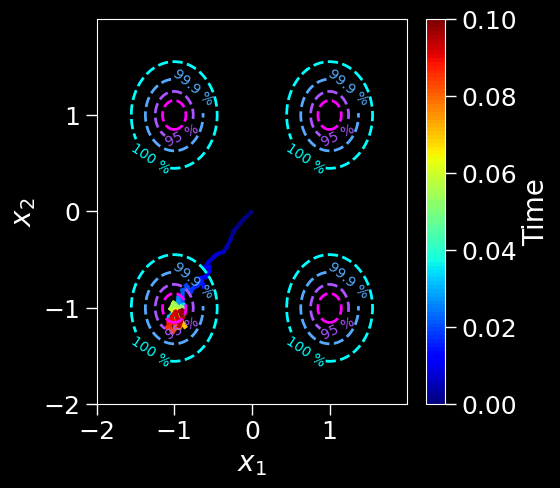

In [6]:
# @title Visualize a Langevin SDE with the distribution log probability as potential

dt = 1e-3
iterations = 100
sigma_init = 0.01
x = torch.randn([W, 2]) * sigma_init # some initial conditions
langevin_walk = [x]
for _ in range(iterations):
    x = langevin_step(x, dt)
    langevin_walk.append(x.cpu().numpy())
langevin_walk = np.stack(langevin_walk, axis=1)

# Plot the random walk with a color gradient showing evolution
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('jet', iterations)
for w in range(W):
    for i in range(iterations-1):
        ax.plot(langevin_walk[w, i:i+2, 0], langevin_walk[w, i:i+2, 1], color=cmap(i), lw=3)
# For reference, we plot the density contours on top of the random walk
def density(x):
    return torch.exp(dist.log_prob(x))
ax = density_contours(density, xmin=-2, xmax=2, ymin=-2, ymax=2, confidence_intervals=[0.68, 0.95, 0.999, 0.9999999], ax=ax)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, iterations * dt))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time')

ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");

# Naive score matching

We now consider the simplest and most naive way to learn the score, assuming we have access to the true density. We will see in the next section how to improve it and deal with situations where we don't have access to the score.

Let us consider the regression task of learning the score directly with a neural network $\mathbf{x}_\theta(\mathbf{x}): \mathbb{R}^n \to \mathbb{R}^n$
$$
  \mathcal{L}_\theta = \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \big[\lVert \mathbf{s}_\theta(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \rVert^2 \big]
$$

The ideas of score matching were first developed by
- [Aapo Hyvarïnen (2005)](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)
- [Pascal Vincent (2011)](https://www.iro.umontreal.ca/~vincentp/Publications/DenoisingScoreMatching_NeuralComp2011.pdf)

A useful resource is [Yang Song's blog post](https://yang-song.net/blog/2021/score/)


In [18]:
# Define a simple R^2 to R^2 neural network architecture
# The simplest such architecture is a Multi-Layer Perceptron (MLP) with 2 channles for its input, an hidden layer and 2 channels in output
from torch import nn
model = ...

def loss_fn(x):
  B = x.shape[0]
  # score is the function you defined above
  return torch.sum((model(x) - score(x))**2) / B

100%|██████████| 5000/5000 [00:16<00:00, 311.39it/s]


Text(0.5, 0, 'Iteration')

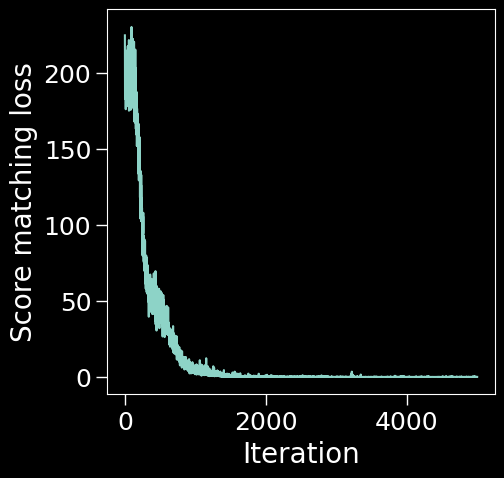

In [19]:
# @title Train the score model with score matching

# Then train this architecture with score matching
iterations = 5000
batch_size = 256
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    loss = loss_fn(x)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0.5, 0, '$x_1$')

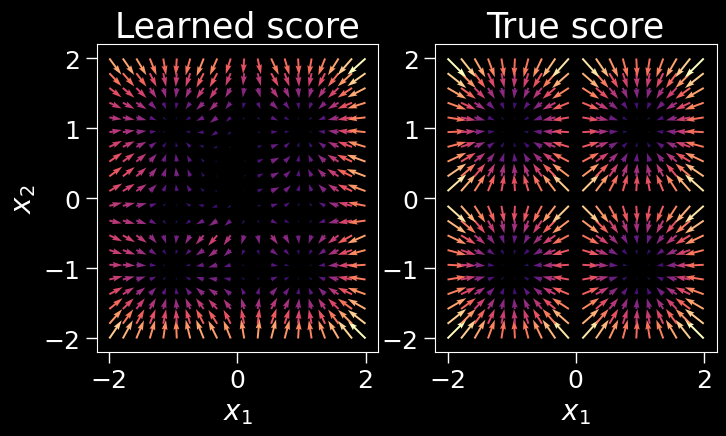

In [20]:
# @title Compare the learned score with the true score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1 = vector_field(model, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, ax=ax1)
ax2 = vector_field(score, xmin=-2, xmax=2, ymin=-2, ymax=2, n=20, dx=0.05, ax=ax2)


ax1.set_title("Learned score")
ax2.set_title("True score")
ax1.set_ylabel(r"$x_2$")
ax1.set_xlabel(r"$x_1$")
ax2.set_xlabel(r"$x_1$")

# Introducing temperatures

Even though we had access to perfect information, we still couldn't learn the score perfectly because we were not exploring the regions of low density! The solution, both to sampling in high dimension and training the score model, is to introduce a temperature schedule to "anneal", or "smooth" the probability density function. The simplest way to anneal a distribution is to "add noise", so to speak.

Suppose $\mathbf{x}_0 \sim p(\mathbf{x}_0)$ is a sample from our true distribution (`dist` in this code). We will perturb our sample with noise at temperature $\sigma^2(t)$. In what follow, I will denote $\mathbf{z}$ as a normal random variable, which you can always sample using `torch.randn()`
$$
  \mathbf{z} \sim \mathcal{N}(0, \mathbb{1})
$$
The perturbed sample is denoted by $\mathbf{x}_t$:
$$
  \mathbf{x}_t = \mathbf{x}_0 + \sigma(t)\mathbf{z}
$$
A more compact way of writing this is in terms of the perturbation kernel, which is the distribution of $\mathbf{x}_t$ given $\mathbf{x}_0$ (in other words, the distribution of $\sigma(t)\mathbf{z}$)
$$
  p(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0, \sigma^2(t)\mathbb{1})
$$

Conceptually, this procedure amounts in a smoothing of the original distribution $p(\mathbf{x}_0)$. Indeed, the addition of two random variable results in the convolution of their probability distributions
$$
  p(\mathbf{x}_t) = \int\, d \mathbf{x}_0 p(\mathbf{x}_0) p(\mathbf{x}_t \mid \mathbf{x}_0)
$$
You can look in [this wikipedia page](https://en.wikipedia.org/wiki/List_of_convolutions_of_probability_distributions)
for a list of useful results. Since we are working with a Gaussian mixture, we can actually evaluate this integral analytically. The solution is in the link above. I will simply quote the result here, where I have denoted $\mu_i$ and $\sigma$ as the mean and standard deviation of the mixture I have defined above (`dist`):
\begin{align}
    p_t(\mathbf{x}_t) &= \frac{1}{4}\sum_{i=1}^4 \int d \mathbf{x}_0 \mathcal{N}(\mathbf{x}_0 \mid \boldsymbol{\mu}_i, \sigma^2 \mathbb{1}_n) \circledast \mathcal{N}(0, \sigma^2(t)\mathbb{1}) \\
      &=  \frac{1}{4}\sum_{i=1}^4 \mathcal{N}(\boldsymbol{\mu}_i, (\sigma^2 + \sigma(t)^2)\mathbb{1}_n)
\end{align}


In the code below, you will define the Variance Exploding (VE) schedule
for the temperature, i.e.
$$
  \sigma(t) = \sigma_\min \left(\frac{\sigma_\max}{\sigma_\min}\right)^t
$$


In [21]:

# First define a temperature schedule. We use some foresight and use a geometric series
sigma_x0 = 0.1 # the original width of our modes (don't change this)
sigma_min = ... # minimum temperature (pick a number, ideally small)
sigma_max = ... # maximum temperature (pick a number, ideall larger than the distance between the modes)

def sigma(t):
  # Create your temperature schedule
  return ...

def perturb_sample(x, t):
  # Sample from the perturbation kernel
  return ...

In [22]:
# I redefine some quantities so that they are also conditioned on time
def log_prob(x, t):
    """
      Define the distribution at the correct temperature, then evalute log_prob
    """
    width = torch.sqrt(sigma_x0**2 + sigma(t)**2)
    return four_gaussians(mode_width=width).log_prob(x)

def score(x, t):
    return vmap(grad(log_prob))(x, t)

def density(x, t):
    return torch.exp(log_prob(x, t))

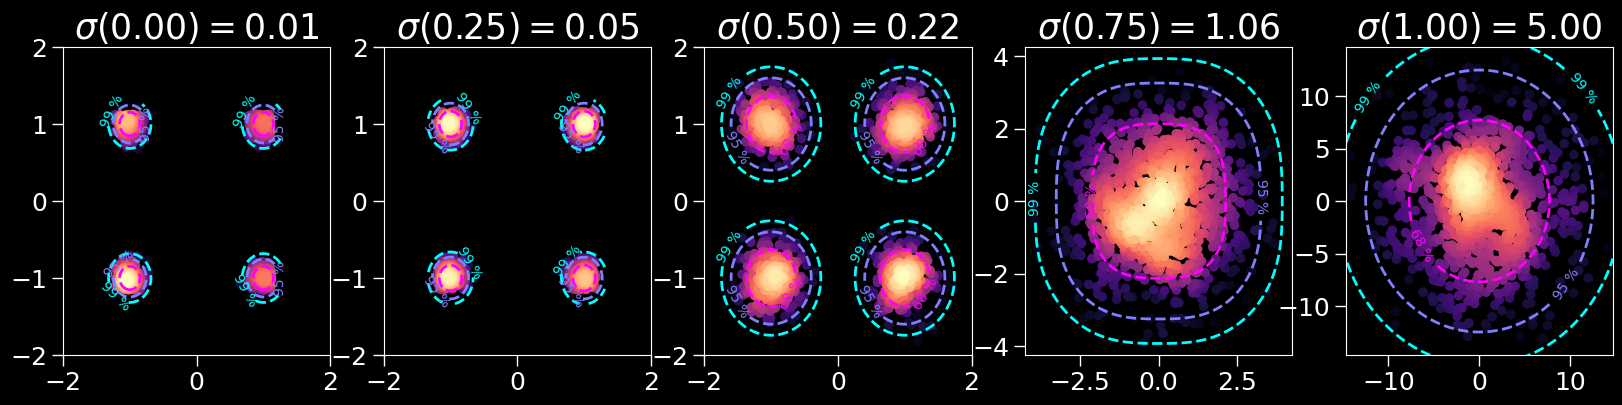

In [23]:
# @title Visualize the effect of adding noise on the probability contour of the distribution
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

ts = [0, 0.25, 0.5, 0.75, 1]
_max = [2, 2, 2, 4, 8]
N = 1000
for i, t in enumerate(ts):
    x = dist.sample([N])
    x_t = perturb_sample(x, t)
    ax_i = density_scatter(x_t.cpu().numpy(), ax=axs[i], bins=10)
    ax_i = density_contours(lambda x: density(x, torch.tensor(t)), xmin=x_t.min(), xmax=x_t.max(), ymin=x_t.min(), ymax=x_t.max(), confidence_intervals=[0.68, 0.95, 0.99], ax=ax_i)

    if x_t.max() < 2: # a small hack to make plotting pretty
      ax_i.set_ylim(-2, 2)
      ax_i.set_xlim(-2, 2)
    else:
      ax_i.set_ylim(-x_t.max(), x_t.max())
      ax_i.set_xlim(-x_t.max(), x_t.max())
    ax_i.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

# Learning the score at every temperatures

We will now modify the learning objective used above so that our neural network
learns the score at every temperature. This will allow the network to be trained on inputs covering the entire space, not just where our target distribution has high density.

**Note**: In practice, you do not have access to the true score. In the last cell of this notebook, we will modify this loss slightly using [Vincent et al. (2011)](https://www.iro.umontreal.ca/~vincentp/Publications/DenoisingScoreMatching_NeuralComp2011.pdf) connection to
make the loss work when we only have access to samples.

The way to modify the score matching objective is relatively simple. We need to add a score matching objectve **at every temperature**. We define the time index $t \in [0, 1]$ in a continuous fashion. We also condition the neural network on the time index. With these modifications, we obtain the following objective
$$
  \mathcal{L}_\theta = \int dt\,
  \mathbb{E}_{ p(\mathbf{x}_t, \mathbf{x}_0)}\bigg[
  \lambda(t)
  \big\lVert
    \mathbf{s}_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)
    \big\rVert_2^2
     \bigg]
$$

Let us clarify what is going on. At every temperature $t$, we perturb a sample to obtain $\mathbf{x}_t$, then we measure the difference between our score model, $\mathbf{s}_\theta(\mathbf{x}_t, t)$, and the true score, $\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)$.

We can rewrite this loss a little bit to to clarify some things
$$
  \mathcal{L}_\theta =  
  \mathbb{E}_{t \sim \mathcal{U}(0, 1)}
  \mathbb{E}_{\mathbf{x}_0 \sim p(\mathbf{x}_0)}
  \mathbb{E}_{\mathcal{x}_t \sim p(\mathbf{x}_t \mid \mathbf{x}_0)}
  \bigg[\lambda(t)
    \big\lVert \mathbf{s}_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}} p_t(\mathbf{x}_t)
  \big\rVert^2_2 \bigg]
$$
This way of writing the loss essentially illustrate the following steps:
1. Sample $\mathbf{x}_0$ from your dataset (I will do this step for you in the code below);
2. Sample $t \sim \mathcal{U}(0, 1)$, where $\mathcal{U}(0, 1)$ is the uniform distribution;
3. Sample $\mathbf{x}_t \sim \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0)$, the perturbation kernel (the function `perturb_sample(x, t)` could be doing that)
4. Compute the MSE between the score model and the score of the annealed distribution.

- I have introduced a weighting factor, $\lambda(t) = \sigma^2(t)$, which we simply set to $\sigma^2(t)$ in this introduction. You will have to code this in the loss function.


We will also introduce a trick of the trade in order to speed up the learning. We need to rescale the output of the network by $1 / \sigma(t)$.  In essence, this comes from the fact that we already know what the magnitude of the score should be when we choose an annealing schedule. As such, we better encode this information directly in the way we model the score, and not let the neural network have to figure it out by itself (which is very hard as it turns out)
$$
  \mathbf{s}_\theta(\mathbf{x}, t) = \frac{\boldsymbol{\epsilon}_\theta(\mathbf{x}, t)}{\sigma(t)}
$$

In the code below, I have defined a neural architecture for $\epsilon(\mathbf{x}, t)$. You need to define the function `score_model(model, x, t)` to implement this rescaling. Be careful with tensor shapes.
- $t$ should have a batch dimension, i.e. `t.shape = [B]`
- $\mathbf{x}$ should have a batch dimension and a channel dimension, i.e. `x.shape = [B, 2]`

In [25]:
# I redefine the neural network architecture to be conditioned on time
class Model(nn.Module):
    def __init__(self, scale=16, embed_dim=32, units=100):
        super().__init__()
        self.nn1 = nn.Linear(2+embed_dim, units)
        self.nn2 = nn.Linear(units, units)
        self.nn3 = nn.Linear(units, 2)
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_proj = t.view(-1, 1) * self.W[None, :] * 2 * np.pi
        temb = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=1)
        x = torch.cat([x, temb], dim=1)
        x = self.nn1(x)
        x = self.act(x)
        x = self.nn2(x)
        x = self.act(x)
        x = self.nn3(x)
        return x # returns epsilon_theta(x, t)

def score_model(model, x, t):
    t = t.view(-1, 1) # this is useful
    # returns s_theta(x, t)
    return ...

def loss_fn(x):
    """
    Given a batch of samples from the dataset, perturb them at different t and compute the score matching loss.
    - Remember to send your tensors on DEVICE
    - Be careful with shapes, especially quantities that depend on t that might be missing the channel dimension (remember broadcasting rules)
    - Don't forget the lambda(t) factor weighting the loss.
    """
    B = x.shape[0] # this is useful, it's the batch size
    # Define the continuous-time densoising score matching loss
    return...



100%|██████████| 15000/15000 [01:30<00:00, 165.03it/s]


Text(0.5, 0, 'Iteration')

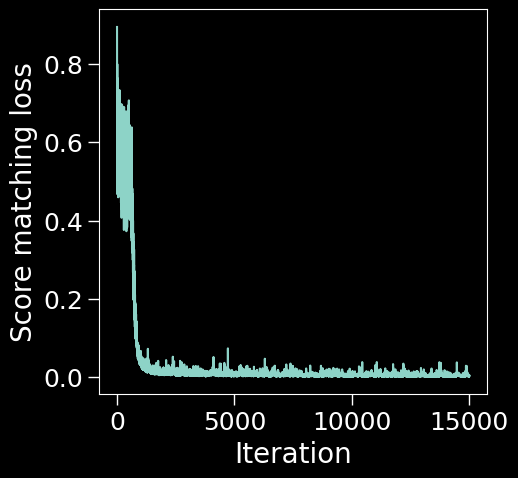

In [26]:
# @title Train a neural network conditioned on time

model = Model()
iterations = 15000
batch_size = 256
learning_rate = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    loss = loss_fn(x)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0, 0.5, 'True score')

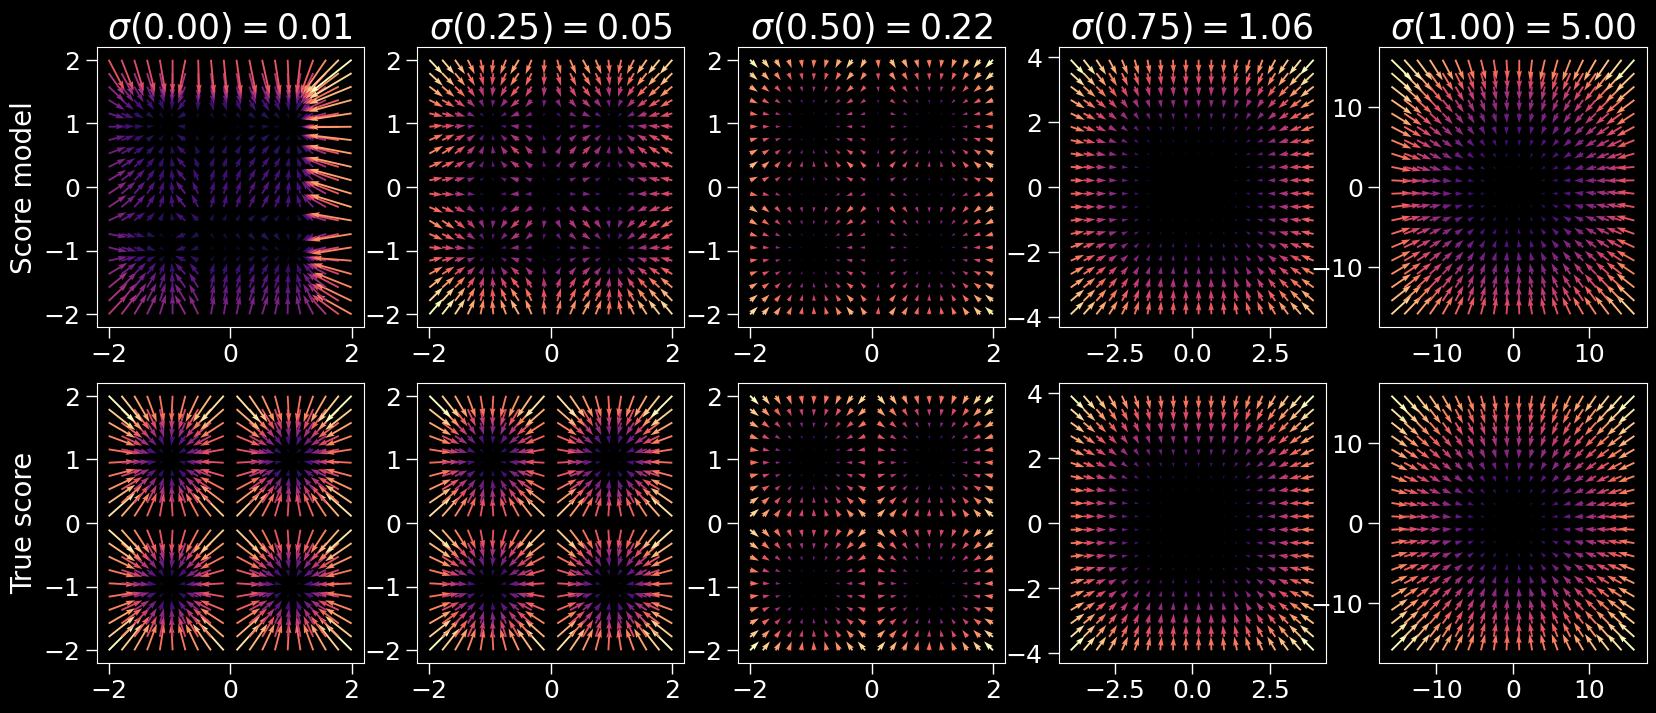

In [86]:
# @title Compare the learned score with the true one at different temperatures
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1e3, 1e3, 5e2, 5e1, 1e1]
for i, t in enumerate(ts):
    # Figure out the min and max of the plot
    x = dist.sample([N])
    x_t = perturb_sample(x, t)
    _max = 2 if x_t.max() < 2 else x_t.max()
    ax1 = vector_field(lambda x: score_model(model, x, torch.ones(20**2).to(DEVICE)*t), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, n=20, dx=0.05, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: score(x, torch.ones(20**2).to(DEVICE)*t), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, n=20, dx=0.05, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

# Sampling using a Stochastic Differential Equation (SDE)

**Note**: The score at low temperature will likely still be bad with our new strategy. As you will see, this will not be a problem if we care about sampling from the distribution. The score at higher temperature (which is likely to be good), will help us tremendously!

Now that we have a score function, be it good or bad, we are in a better position to sample from the sequence of annealed distribution we have defined above. But first, we need to make a connection between annealing (i.e., adding noise), and SDEs.

Adding noise to a sample, or perturbing it like we did before: $\mathbf{x}_t = \mathbf{x}_0 + \sigma(t)\mathbf{z}$, can be accomplished in an equivalent fashion using Brownian motion. The difference here is that when we integrate the stochastic process up to time $t$, we should have walked a distance $\sigma(t)$ on average, not $\sqrt{t}$. We will accomplish this with the following construction:
$$
  d\mathbf{x} = g(t) d \mathbf{w}
$$
$g(t)$ is called the diffusion coefficient and $d\mathbf{w}$ is an infinitesimal Wiener process. When using a Wiener process like this, we are adding infinitesmial amounts of noise to our samples. The underlying distribution is then transformed by an ordinary differential equation, which we call the [Fokker-Planck equation](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation) (analoguous to our convolution before, but for an infinitesimal process)
$$
  \frac{d p_t(\mathbf{x})}{dt} = \frac{1}{2}g^2(t) \Delta p_t(\mathbf{x})
$$
You might recognize the heat equation. To figure out the diffusion coefficient $g(t)$, we could try to solve the FP equation and extract the diffusion coefficient. An easier way to figure it out is to write a differential equation for the moments of the distribution. This is a bit more approximate, and assumes our distribution is Gaussian. But, we can construct and ODE for the mean and variance of $p_t(\mathbf{x}_t)$. As it turns out, our noising process keeps the mean unchanged, but the variance of the distribution, $\sigma^2(t)$, will evolve under the ODE
([see Särkkä & Solin 2019, eq. 5.51](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf))
$$
  \sigma^2(t) = \int_0^t g^2(s) ds + \sigma^2(0)
$$
Using the fundamental theorem of calculus, we have that
$$
  g(t) = \sqrt{\frac{d \sigma^2(t)}{dt}}
$$

If you used the VE schuedule, we can solve this analytically to get
$$
  g_{\mathrm{VE}}(t) = \sigma(t) \sqrt{2(\log \sigma_\max - \log \sigma_\min)}
$$

You could also use automatic differentiation if you used another schedule and are too lazy to compute the derivative. Note that I have assumed that the diffusion **is homogeneous**, i.e. only depends on $t$.

In [36]:
# @title Define the diffusion coefficient and define the Euler-Maruyama discretisation of the noising process
def g(t):
    return ...

def noising_process_step(x, t, dt):
    # Define a single discretized step of the SDE noising process
    return ...

W = 100 # number of walkers to plot
plot_contours = True # Plotting contours is slow, turn off if you are debugging

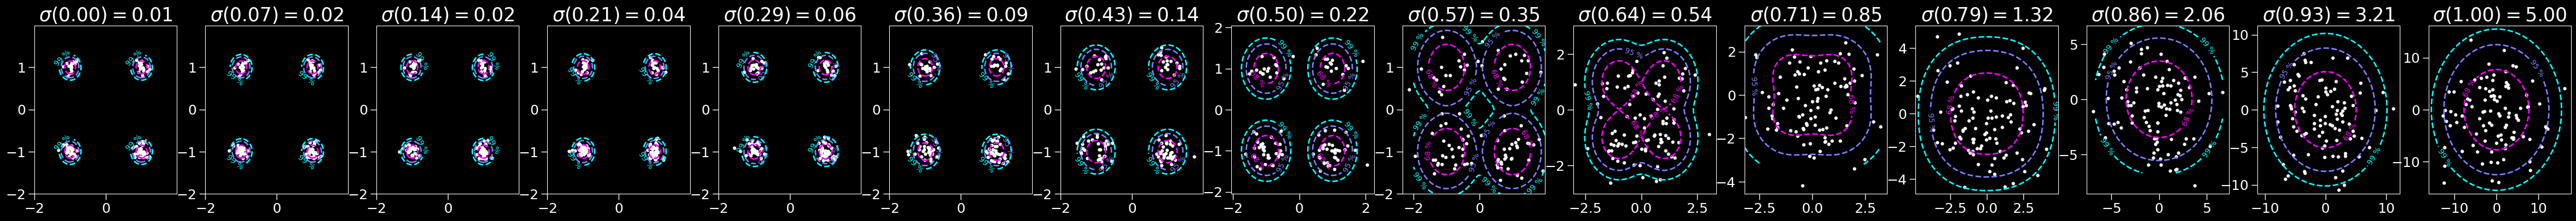

In [37]:
# @title Visualization of the SDE noising process
# initial condition
x = dist.sample([W])

len_frames = 15
ts, dt = np.linspace(0, 1, len_frames, retstep=True)
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
for i in range(len_frames):
    x = noising_process_step(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt)
    axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
    _max = 2 if x.max() < 2 else x.max()
    # for reference, draw the contours of the marginal in time like before
    if plot_contours:
      density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, confidence_intervals=[0.68, 0.95, 0.99], ax=axs[i])
    axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (ts[i], sigma(ts[i])))

## Anderson reverse-time formula

While it may look like extra work to define the noising process as an SDE, it does allow us to use a very cool trick, which is [Anderson's reverse-time formula](https://core.ac.uk/download/pdf/82826666.pdf).

The core idea of this formula is that, while the SDE dynamics itself is not reversible (you would need to have knowledge about the Brownian random variable at **every steps** in order to reverse it), you can reverse the time in the Fokker-Planck equation (since it is a deterministic ODE).

As such, there exist an SDE, which runs backward in time, that respects the same Fokker-Planck equation as our original noising process. This SDE is given by Anderson's reverse-time formula:
$$
  d \mathbf{x} = -g(t)^2\nabla_{\mathbf{x}} \log p_t(\mathbf{x}) dt + g(t) d \bar{\mathbf{w}}
$$
$\bar{\mathbf{w}}$ is a reverse-time brownian motion. In practice, it can
be approximated very similarly to $d \mathbf{w}$, but accounting for the negative time-step $dt < 0$:
$$
  \bar{\mathbf{w}} \approx \mathbf{z}\sqrt{-dt}
$$

In [43]:
def denoising_process_step(x, t, dt):
    # A discretised step of Anderson's reverse-time formula. You can use either your score model or the true score here to compare
    return ...

W = 100 # number of walkers to plot
plot_contours = True # Plotting contours is slow, turn off if you are debugging

# Make sure to set the initial condition at the high temperature boundary condition of your SDE!
x = torch.randn([W, 2]) * sigma(torch.ones(1)).view(-1, 1)

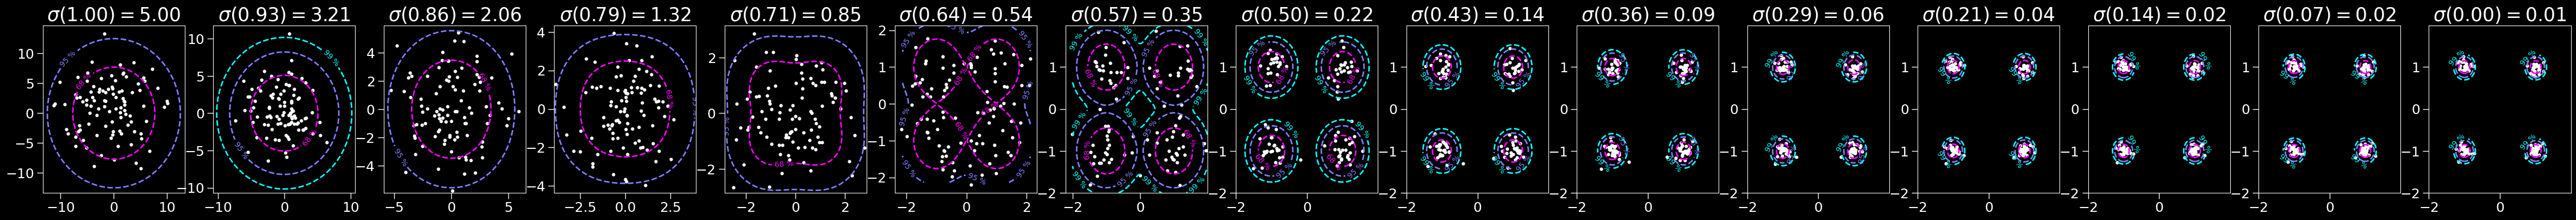

In [44]:
# @title Visualize Anderson's reverse-time SDE

len_frames = 15
ts, dt = np.linspace(1, 0, len_frames, retstep=True)
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
with torch.no_grad():
  for i in range(len_frames):
      x = denoising_process_step(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt) # You can use true_score or model here
      axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
      _max = 2 if x.max() < 2 else x.max()
      if plot_contours:
        density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, confidence_intervals=[0.68, 0.95, 0.99], ax=axs[i])
      axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (ts[i], sigma(ts[i])))

# Denoising score matching

In this last section, we touch on the last important question: what to do if we only have samples from a distribution? This is a very common situation in ML. For examples, you might have images of cat, but do not have the distribution describing what cats look like.

To accomplish this, we use what is called **denoising score matching** (DSM). The connection of this loss with score matching was first discovered by [Vincent 2011](https://www.iro.umontreal.ca/~vincentp/Publications/DenoisingScoreMatching_NeuralComp2011.pdf). The connection can be summarised as follows. The score matching loss
$$
  \mathcal{L}_\theta = \int dt\,
  \mathbb{E}_{ p(\mathbf{x}_t, \mathbf{x}_0)}\bigg[
  \lambda(t)
  \big\lVert
    \mathbf{s}_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)
    \big\rVert_2^2
     \bigg]
$$
is completely equivalent to the score matching loss targeting the **perturbation kernel** instead of the score function $\nabla_{\mathbf{x}_t}\log p_t (\mathbf{x}_t)$:
$$
  \mathcal{L}_\theta = \int dt\,
  \mathbb{E}_{ p(\mathbf{x}_t, \mathbf{x}_0)}\bigg[
  \lambda(t)
  \big\lVert
    \mathbf{s}_\theta(\mathbf{x}_t, t) - \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t \mid \mathbf{x}_0)
    \big\rVert_2^2
     \bigg]
$$
These two quantities are equal up to a constant, which does not matter when we take gradients relative to $\theta$.

Using our reparameterization of the perturbation kernel, we can easily evaluate its score
$$
  \nabla_{\tilde{\mathbf{x}}} p_t(\tilde{\mathbf{x}} \mid \mathbf{x}_0) = -\frac{\mathbf{z}}{\sigma_t}
$$

In the code below, you will rewrite your score matching loss in terms of the perturbation kernel instead of the true score.

**Note**: To do this, do not use the function `perturb_sample`, and instead rewrite it explicitly in your loss to have access to the random variable $\mathbf{z}$.

In [45]:
model = Model()

def score_model(model, x, t):
    t = t.view(-1, 1)
    return model(x, t) / sigma(t)

def loss_fn(x):
    # Define the denoising score matching loss function, without using the true score (i.e. you need to target -z / sigma(t))
    # Careful with your sign!
    B = x.shape[0] # this is useful, it's the batch size
    # Define the continuous-time densoising score matching loss
    return ...



100%|██████████| 50000/50000 [02:40<00:00, 312.50it/s]


Text(0.5, 0, 'Iteration')

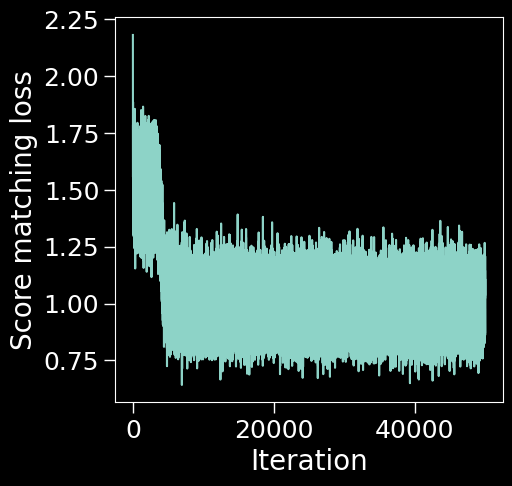

In [46]:
# @title Train your score model with Densoising Score Matching
# Finally, here is how you would construct the training algorithm
iterations = 50000
batch_size = 256
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in tqdm(range(iterations)):
    optimizer.zero_grad()
    x = dist.sample([batch_size])
    loss = loss_fn(x)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.ylabel("Score matching loss")
plt.xlabel("Iteration")

Text(0, 0.5, 'True score')

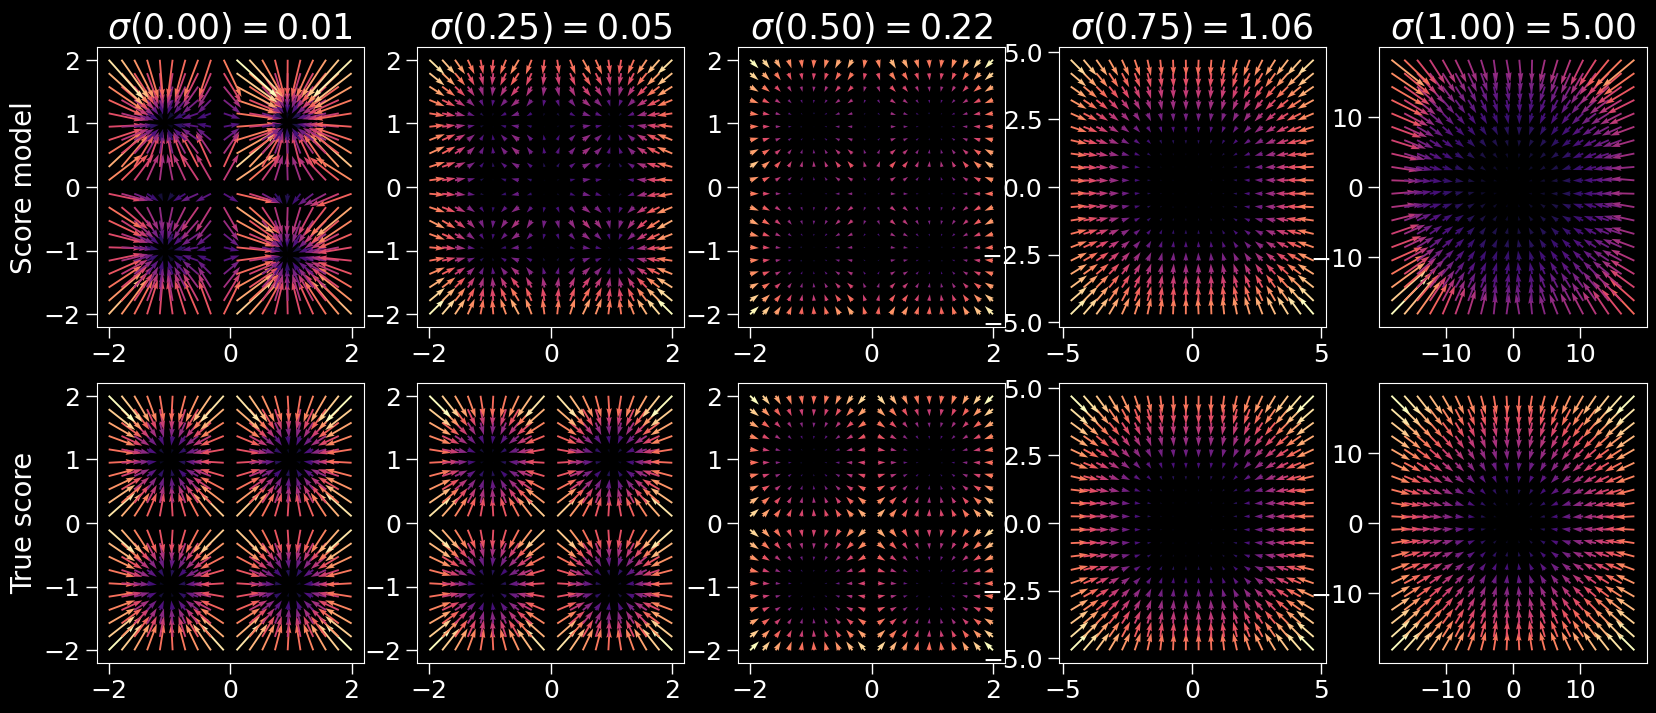

In [47]:
# @title Compare the learned score with the true one at different temperatures
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


ts = [0, 0.25, 0.5, 0.75, 1]
scales = [1e3, 1e3, 5e2, 5e1, 1e1]
for i, t in enumerate(ts):
    # Figure out the min and max of the plot
    x = dist.sample([N])
    x_t = perturb_sample(x, t)
    _max = 2 if x_t.max() < 2 else x_t.max()
    ax1 = vector_field(lambda x: score_model(model, x, torch.ones(20**2).to(DEVICE)*t), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, n=20, dx=0.05, scale=scales[i], ax=axs[0, i])
    ax2 = vector_field(lambda x: score(x, torch.ones(20**2).to(DEVICE)*t), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, n=20, dx=0.05, scale=scales[i], ax=axs[1, i])
    ax1.set_title(f"$\sigma(%.2f) = %.2f$" % (t, sigma(t)))

axs[0, 0].set_ylabel(r"Score model")
axs[1, 0].set_ylabel(r"True score")

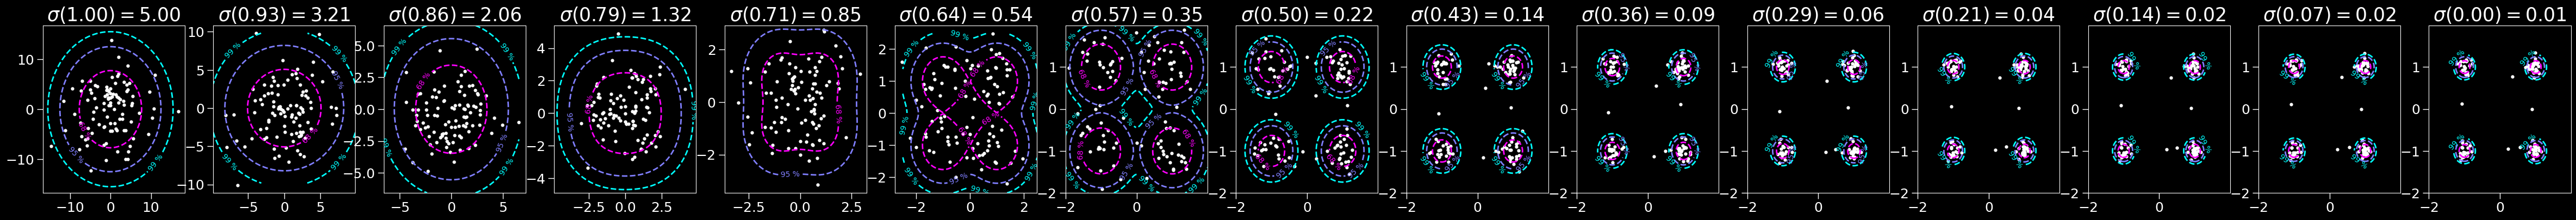

In [48]:
# @title Visualize the sampling process from the diffusion model

x = torch.randn([W, 2]) * sigma(torch.ones(1)).view(-1, 1)

len_frames = 15
ts, dt = np.linspace(1, 0, len_frames, retstep=True)
fig, axs = plt.subplots(1, len_frames, figsize=(4*len_frames, 4))
with torch.no_grad():
  for i in range(len_frames):
      x = denoising_process_step(x, torch.ones(x.shape[0]).to(DEVICE) * ts[i], dt) # You can use true_score or model here
      axs[i].plot(x.numpy()[:, 0], x.numpy()[:, 1], "w.", markersize=7)
      _max = 2 if x.max() < 2 else x.max()
      if plot_contours:
        density_contours(lambda x: density(x, torch.tensor(ts[i])), xmin=-_max, xmax=_max, ymin=-_max, ymax=_max, confidence_intervals=[0.68, 0.95, 0.99], ax=axs[i])
      axs[i].set_title(f"$\sigma(%.2f) = %.2f$" % (ts[i], sigma(ts[i])))